# Extraindo arquivos:

In [1]:
import numpy as np
import tensorflow as tf
from zipfile import ZipFile
import tensorflow_io as tfio
from matplotlib import pyplot as plt
import os

2023-09-26 22:02:48.248924: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-26 22:02:48.462567: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-26 22:02:48.464334: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 22:02:49.771435: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
with ZipFile('gac.zip', 'r') as zipObj:
  zipObj.extractall('data')

In [3]:
with ZipFile('pia.zip', 'r') as zipObj:
  zipObj.extractall('data')

In [4]:
with ZipFile('vio.zip', 'r') as zipObj:
  zipObj.extractall('data')

## Função de conversão:
De arquivo para onda

In [5]:
def load_wav_16k_mono(filename):
  file_contents = tf.io.read_file(filename)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000) # TODO: Verificar se nessa qualidade está ok
  return wav

## Plotando onda

In [6]:
PIANO_SAMPLE_FILE = os.path.join('data', 'pia', '001__[pia][nod][cla]1389__1.wav')
GUITAR_SAMPLE_FILE = os.path.join('data', 'gac', '014__[gac][nod][cou_fol]0770__1.wav')
VIOLIN_SAMPLE_FILE = os.path.join('data', 'vio', '001__[vio][nod][cou_fol]2194__2.wav')

In [7]:
pwave = load_wav_16k_mono(PIANO_SAMPLE_FILE)
gwave = load_wav_16k_mono(GUITAR_SAMPLE_FILE)
vwave = load_wav_16k_mono(VIOLIN_SAMPLE_FILE)

2023-09-26 22:03:01.233035: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX AVX2 FMA


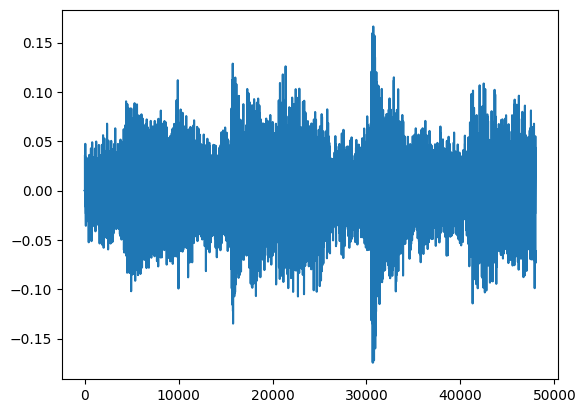

In [8]:
# Onda PIANO
plt.plot(pwave)
plt.show()

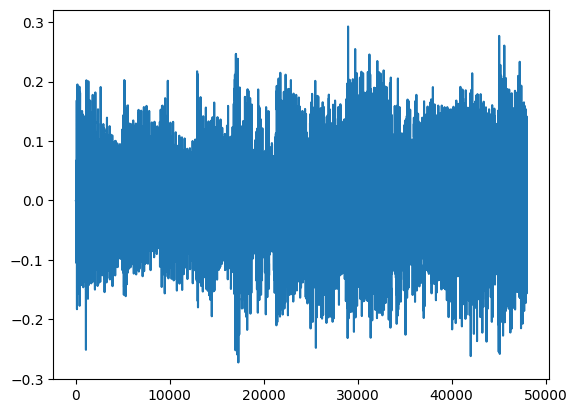

In [9]:
# Onda VIOLÃO
plt.plot(gwave)
plt.show()

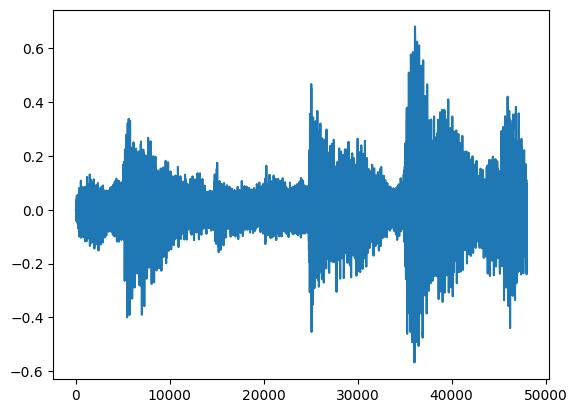

In [10]:
# Onda VIOLINO
plt.plot(vwave)
plt.show()

# Criando dataset

In [11]:
PIANO = os.path.join('data', 'pia') # , '*.wav')
GUITAR = os.path.join('data', 'gac')
VIOLIN = os.path.join('data', 'vio')

In [12]:
# Tensor com caminho dos arquivos
piano = tf.data.Dataset.list_files(PIANO + '/*.wav')
guitar = tf.data.Dataset.list_files(GUITAR + '/*.wav')
violin = tf.data.Dataset.list_files(VIOLIN + '/*.wav')

### Adicionando labels

In [13]:
# TESTE
a = tf.keras.utils.to_categorical(tf.fill(len(guitar), 2), num_classes=3)
a

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [14]:
pianoLab = tf.data.Dataset.zip(piano, tf.data.Dataset.from_tensor_slices(
    tf.keras.utils.to_categorical(tf.fill(len(piano), 0), num_classes=3) # Label [1,0,0] para piano
))
guitarLab = tf.data.Dataset.zip(guitar, tf.data.Dataset.from_tensor_slices(
    tf.keras.utils.to_categorical(tf.fill(len(guitar), 1), num_classes=3) # Label [0,1,0] para violão
))
violinLab = tf.data.Dataset.zip(violin, tf.data.Dataset.from_tensor_slices(
    tf.keras.utils.to_categorical(tf.fill(len(violin), 2), num_classes=3) # Label [0,0,1] para violino
))

data = pianoLab.concatenate(guitarLab)
data = data.concatenate(violinLab)

In [15]:
data.as_numpy_iterator().next()

(b'data/pia/[pia][jaz_blu]1372__2.wav', array([1., 0., 0.], dtype=float32))

## Verificando tamanho médio dos áudios
Percebemos que todos têm o mesmo tamanho

In [16]:
lenghts = []

for file in os.listdir(os.path.join('data', 'gac')):
  tensor_wave = load_wav_16k_mono(os.path.join('data', 'gac', file))
  lenghts.append(len(tensor_wave))

In [17]:
tf.math.reduce_mean(lenghts)

<tf.Tensor: shape=(), dtype=int32, numpy=47999>

In [18]:
tf.math.reduce_min(lenghts)

<tf.Tensor: shape=(), dtype=int32, numpy=47999>

In [19]:
tf.math.reduce_max(lenghts)

<tf.Tensor: shape=(), dtype=int32, numpy=47999>

# Convertendo em Espectrograma

In [20]:
def preprocess(file_path, label):
  wav = load_wav_16k_mono(file_path)

  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32) # TODO: Verificar frame_length
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram, label

## Testando

In [21]:
filepath, label = violinLab.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

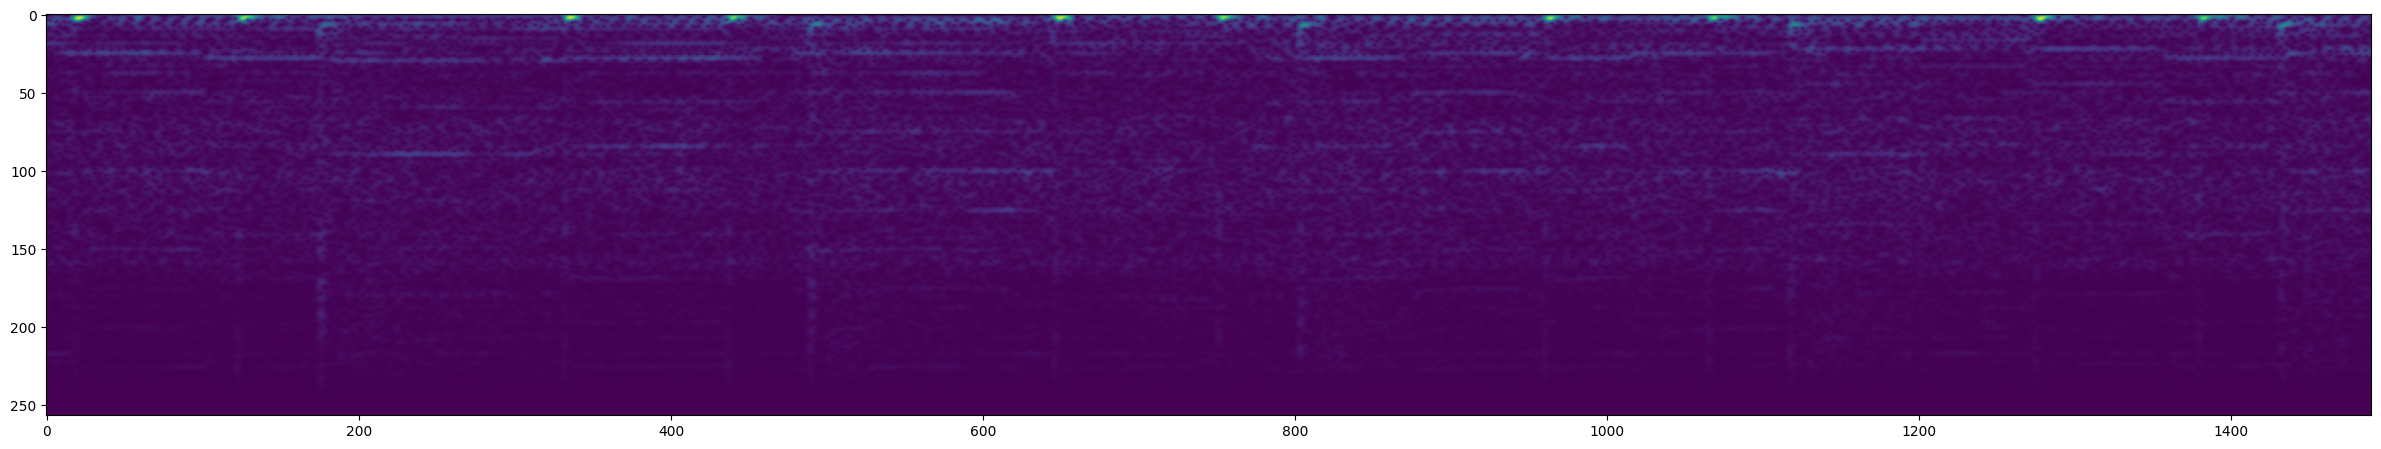

In [22]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Separando partições e convertendo data

In [23]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=10000)
data = data.batch(16)
data = data.prefetch(8)

In [24]:
train = data.take(86) # 86 +- 70% de 122
test = data.skip(86).take(36) # 36 restantes para teste

In [25]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

2023-09-26 22:03:48.256596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 989 of 10000
2023-09-26 22:03:57.226962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


(16, 1490, 257, 1)

# Criando modelo de CNN

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [28]:
# Projetando modelo:

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(1490, 257, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax')) # 3 é o número de classes da resposta

2023-09-26 22:04:43.100606: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1519616000 exceeds 10% of free system memory.
2023-09-26 22:04:43.695503: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1519616000 exceeds 10% of free system memory.
2023-09-26 22:04:43.981871: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1519616000 exceeds 10% of free system memory.


In [29]:
model.compile('Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1488, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 744, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 742, 125, 32)      4640      
                                                                 
 flatten (Flatten)           (None, 2968000)           0         
                                                                 
 dense (Dense)               (None, 128)               379904128 
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                        

In [31]:
# Treinando modelo:

hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4


2023-09-26 22:05:58.173427: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1519616000 exceeds 10% of free system memory.
2023-09-26 22:05:58.399643: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1519616000 exceeds 10% of free system memory.


86/86 [==============================] - 725s 8s/step - loss: 8.2092 - accuracy: 0.5814 - val_loss: 0.7048 - val_accuracy: 0.7438
Epoch 2/4
86/86 [==============================] - 739s 9s/step - loss: 0.6375 - accuracy: 0.7892 - val_loss: 0.3393 - val_accuracy: 0.8843
Epoch 3/4
86/86 [==============================] - 731s 9s/step - loss: 0.3666 - accuracy: 0.8743 - val_loss: 0.2655 - val_accuracy: 0.8968
Epoch 4/4
86/86 [==============================] - 742s 9s/step - loss: 0.2244 - accuracy: 0.9288 - val_loss: 0.1156 - val_accuracy: 0.9804


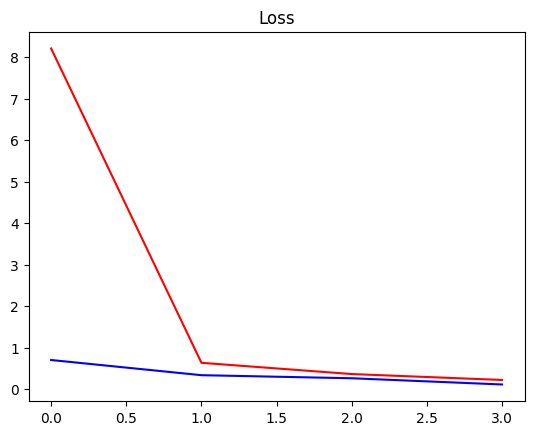

In [32]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

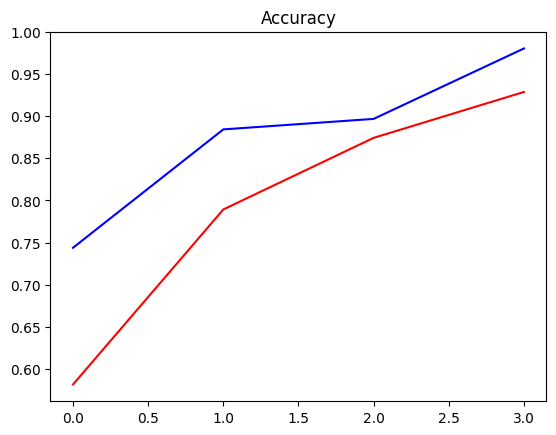

In [35]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.show()

## Testando modelo criado

In [36]:
x_test, y_test = test.as_numpy_iterator().next()

In [43]:
[np.where(c==1)[0][0] for c in y_test]

[0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 0, 1, 2]

In [38]:
yhat = model.predict(x_test)

1/1 [==============================] - 1s 699ms/step


In [44]:
[np.argmax(c) for c in yhat]

[0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 0, 1, 2]

In [45]:
model.save('cnn_model.keras')

/home/racklyn/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import json

# Saving history:
with open('cnn_train_history.json', 'w') as json_file:
    json.dump(hist.history, json_file)

In [ ]:
# Loading history:
# with open('cnn_train_history.json', 'r') as json_file:
#     loaded_hist = json.load(json_file)

# Criando modelo RNN

In [ ]:
from tensorflow.keras.layers import LSTM, Dropout

In [ ]:
# Projetando modelo:

rnnModel = Sequential()
rnnModel.add(LSTM(64, input_shape=(1490, 257), return_sequence=True))
rnnModel.add(LSTM(64))

rnnModel.add(Dense(64, activation='relu'))
#rnnModel.add(Dropout(0.3))

rnnModel.add(Dense(3, activation='softmax')) # 3 é o número de classes da resposta

In [ ]:
rnnModel.compile('Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
rnnModel.summary()

In [ ]:
hist2 = model.fit()